In [1]:
import numpy as np
import pandas as pd
import matplotlib
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.kernel_ridge import KernelRidge
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline
np.set_printoptions(precision=3)

df = pd.read_csv('ttl_daily.csv', names=['date', 'cnt']).ix[1:,:]
print(df.head())

df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date')

         date   cnt
1  01/01/2006  1485
2  01/01/2007  1636
3  01/01/2008  1631
4  01/01/2009  1547
5  01/01/2010  1757


In [8]:
import sys
print(sys.version)

3.5.2 |Anaconda custom (x86_64)| (default, Jul  2 2016, 17:52:12) 
[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]


In [2]:
df = df[df['date'].apply( lambda x: x.year ) >= 2009]

vals = df['cnt'].values
dates = df['date'].values

w = pd.read_csv('central_park_weather.csv')
w.head()
for idx in range(w.shape[0]):
    fs = str(w['DATE'][idx])
    w.ix[idx,'DATE'] = fs[-2:] + '/' + fs[4:6] + '/' + fs[:4]
w['DATE'] = pd.to_datetime(w['DATE'])
w = w.sort_values(by='DATE')
w = w[w['DATE'].apply( lambda x: x.year ) <= 2015]

w.head()

,STATION,STATION_NAME,DATE,PRCP,SNWD,SNOW,TMAX,TMIN,AWND
0,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,2009-01-01,0.00,0.0,0.0,26,15,11.2
31,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,2009-01-02,0.00,1.0,0.0,52,26,7.6
59,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,2009-01-03,0.15,0.0,1.8,36,28,9.8
90,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,2009-01-04,0.36,0.0,0.0,49,43,6.7
120,GHCND:USW00094728,NY CITY CENTRAL PARK NY US,2009-01-05,0.42,0.0,0.0,71,53,6.9


In [3]:
w_vals = w['TMAX'].values*100
w_vals

array([2600, 5200, 3600, ..., 4600, 4800, 4800])

In [4]:
w_vals = (w_vals - np.mean(w_vals)) / np.std(w_vals)

In [5]:
vals = (vals - np.mean(vals)) / np.std(vals)

In [6]:
len(vals)

2556

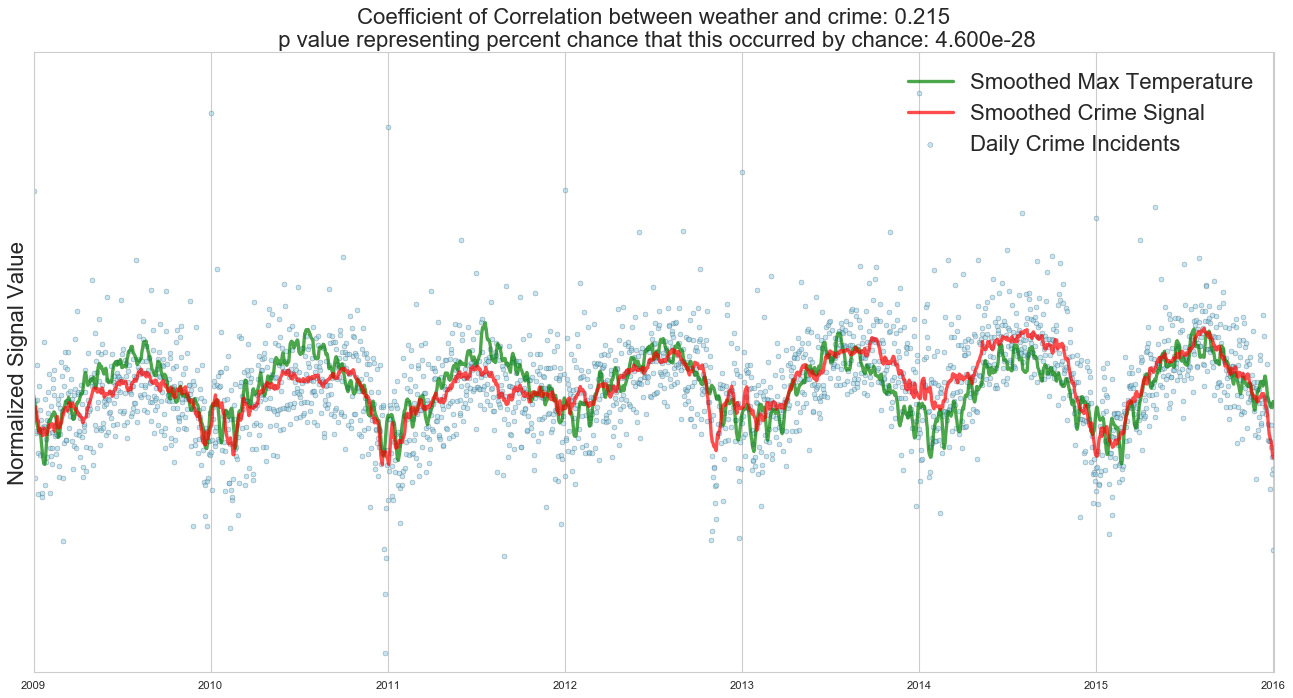

In [7]:
x = np.arange(len(vals))
nb = 10
days = np.arange(len(vals)).reshape([-1,1])

def smooth(x, y, nb):
    y_smooth = np.zeros(x.shape[0])
    for i in range(len(x)):
        if i-nb < 0:
            y_smooth[i] = np.mean(y[:i+11])
        elif i+nb+1 > len(y):
            y_smooth[i] = np.mean(y[i-nb:])
        else:
            y_smooth[i] = np.mean(y[i-nb:i+nb+1])
    return y_smooth
            
            
y_smooth_avg = smooth(x, vals, 10)
smooth_weather = smooth(x, w_vals, 10)


plt.figure(figsize=(20, 10))
plt.plot(days, smooth_weather, c='green', linewidth=3, alpha=.7, label = 'Smoothed Max Temperature')
clf = KernelRidge(alpha=1.0,kernel='rbf')
days = np.arange(len(vals)).reshape([-1,1])
clf.fit(days,vals)
smoothed_values = clf.predict(days)
plt.scatter(days, vals, s=20, alpha=.5, c='skyblue', label = 'Daily Crime Incidents')
plt.plot(days, y_smooth_avg, c='red', alpha=.7, linewidth=3, label = 'Smoothed Crime Signal')
plt.xlim(xmin=0, xmax=len(vals))
plt.ylim(ymin=-6, ymax=7)
plt.xticks(np.arange(0, len(vals)+1, 365).tolist(), np.arange(2009, 2017).tolist())
coef, p_value = pearsonr(w_vals, vals)
plt.title('Coefficient of Correlation between weather and crime: ' + str(np.round(coef, 3)) + 
         '\n p value representing percent chance that this occurred by chance: ' + str(np.array([p_value]))[3:-1],
          fontsize=20)
plt.legend(fontsize = 20)
plt.yticks([])
plt.ylabel('Normalized Signal Value', fontsize = 20)
plt.show()

In [15]:
vals.min()

-5.5965457285811997

In [24]:
str(np.array([p_value]))[3:-1]

'4.600e-28'